## In v0.2, model was trained on all data.  This may be why model overestimates.  Retrain with data filtered for waittime values below threshold.

* Remove start/end from init()
* Add filtering after neighbors created in prepare_source()

In [6]:
from datetime import date, datetime
from BorderModel import BorderImpute
from sklearn.ensemble import ExtraTreesRegressor
from dbhelper import pd_query

imputer = BorderImpute()

# Get source data with neighbor features
source_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                   and (minute = 0 or minute = 30)
                order by c.date;
               '''


In [13]:
from BorderModel import BorderImpute
dfsource = imputer.prepare_source(pd_query(source_query))
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, bootstrap=True, oob_score=True)
imputer.build_model(model)

In [14]:
print imputer.model_ll.oob_score_
print imputer.model_lead.oob_score_
print imputer.model_lag.oob_score_

0.414490065497
0.388761113567
0.381010922235


## OOB score is more reasonable given the difficulty of problem

In [15]:
target_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=5
                   and valid = 1
                   and waittime is not null
                   and (minute = 0 or minute = 30)
                order by c.date;
               '''

target_df = pd_query(target_query)

In [17]:
from BorderModel import emulate_testdata

imputer.prepare_target(emulate_testdata(target_df)).head(20)

,year,month,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2007-01-01 00:30:00,2007,1,0,30,1.923170,NaN,16.500000,NaN
2007-01-01 01:00:00,2007,1,0,60,3.756550,NaN,16.444444,NaN
2007-01-01 01:30:00,2007,1,0,90,4.683210,14,18.142857,NaN
2007-01-01 02:00:00,2007,1,0,120,5.758270,22,13.000000,14.000000
2007-01-01 02:30:00,2007,1,0,150,5.760750,13,NaN,18.571429
2007-01-01 03:00:00,2007,1,0,180,2.070420,NaN,NaN,16.222222
2007-01-01 03:30:00,2007,1,0,210,1.096730,NaN,NaN,16.166667
2007-01-01 04:00:00,2007,1,0,240,0.739786,NaN,NaN,16.000000
2007-01-01 04:30:00,2007,1,0,270,0.541747,NaN,NaN,13.000000


In [18]:
from BorderModel import BorderImpute
imputer.predict()

34316
13446
3620
638
102
17
0


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

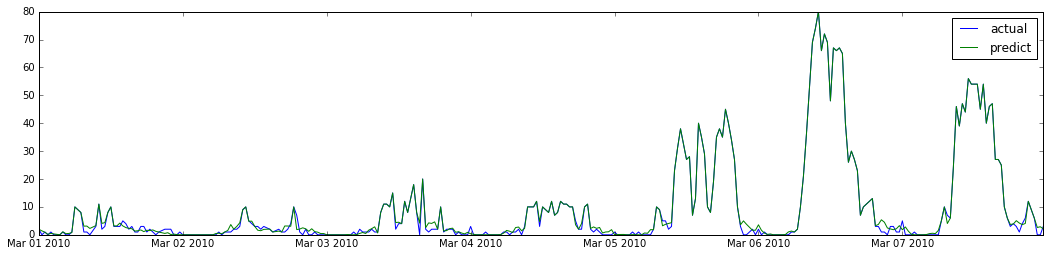

In [21]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

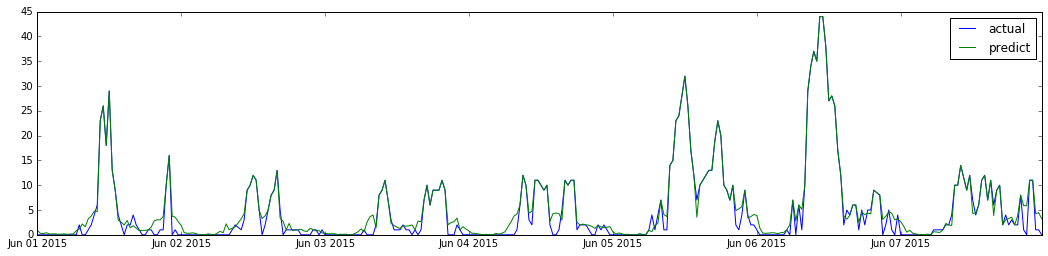

In [22]:
start = '2015-06-01'
end = '2015-06-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

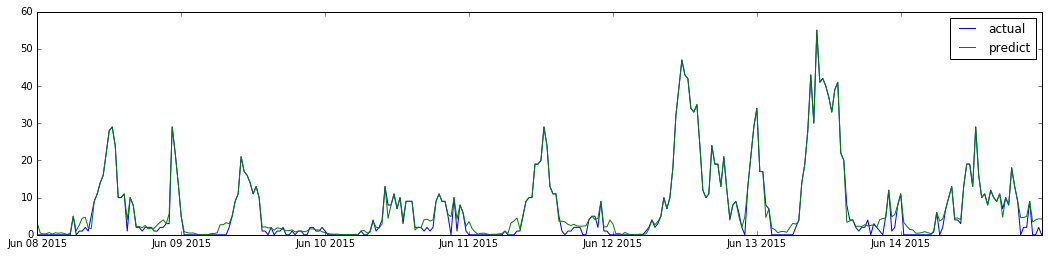

In [28]:
start = '2015-06-08'
end = '2015-06-015'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

In [23]:
from sklearn.metrics import r2_score

r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
         imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

0.0071979242672625121

### R^2 better than constant average prediction

## Scaling factor is smaller now and yields a higher R^2 very close to OOB score

In [26]:
predictdf = imputer.predictdf.copy()[pd.isnull(imputer.targetdf.waittime)]
actualdf = target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)]

from sklearn.metrics import mean_squared_error
def obj_func(x, a, b):
    return mean_squared_error(a, b * x[0])

from scipy.optimize import minimize

minimize(obj_func, .5, args=(actualdf.waittime, predictdf.waittime))

   status: 0
  success: True
     njev: 3
     nfev: 9
 hess_inv: array([[1]])
      fun: 1.5168403576027676
        x: array([ 0.60963442])
  message: 'Optimization terminated successfully.'
      jac: array([  7.45058060e-08])
      nit: 1

In [27]:
r2_score(actualdf.waittime,
         predictdf.waittime * .6)

0.37484827419372335

### Perhaps a model which predicts non-zeros can be used to determine the scaling factor???

## First introduce a decay when model is predicting with only a lead or lag, but not both

Definitely appears to be an issue with values close to peaks

In [29]:
from BorderModel import BorderImpute
imputer.predict()

34316
13446
3620
638
102
17
0


In [30]:
from sklearn.metrics import r2_score

r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
         imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

0.26478848060030646

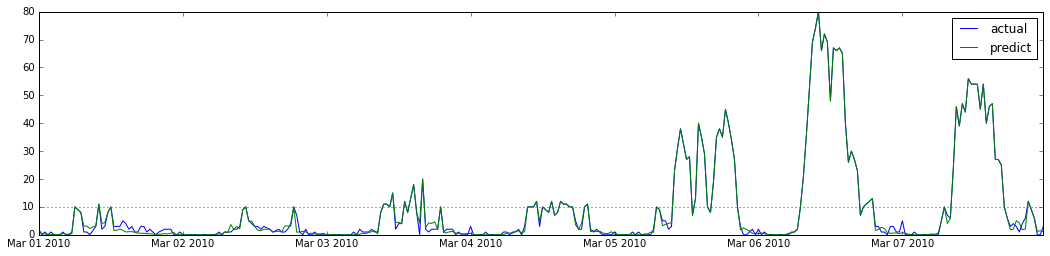

In [43]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.axhline(10, color='r', ls=':')
plt.legend();

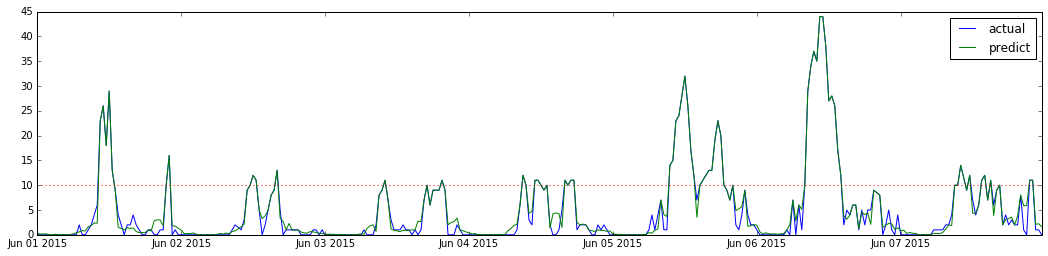

In [42]:
start = '2015-06-01'
end = '2015-06-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.axhline(10, color='r', ls=':')
plt.legend();

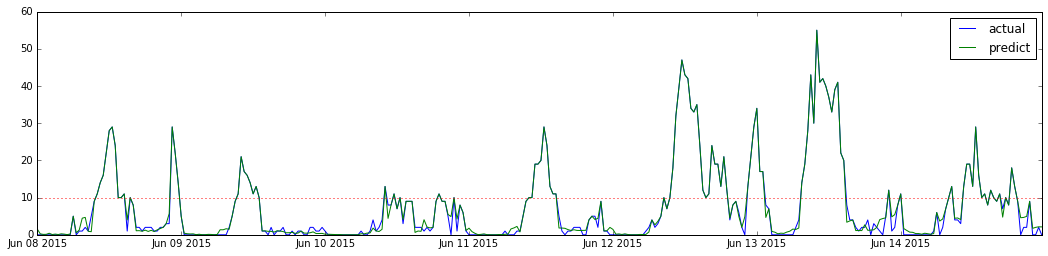

In [41]:
start = '2015-06-08'
end = '2015-06-015'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.axhline(10, color='r', ls=':')
plt.legend();

In [34]:
predictdf = imputer.predictdf.copy()[pd.isnull(imputer.targetdf.waittime)]
actualdf = target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)]

from sklearn.metrics import mean_squared_error
def obj_func(x, a, b):
    return mean_squared_error(a, b * x[0])

from scipy.optimize import minimize

minimize(obj_func, .5, args=(actualdf.waittime, predictdf.waittime))

   status: 0
  success: True
     njev: 3
     nfev: 9
 hess_inv: array([[1]])
      fun: 1.584288447551529
        x: array([ 0.76450567])
  message: 'Optimization terminated successfully.'
      jac: array([  2.98023224e-08])
      nit: 1

In [36]:
r2_score(actualdf.waittime, predictdf.waittime * .75)

0.34697121259877173

### Scaled according to average wait time ratios between crossings

In [44]:
r2_score(actualdf.waittime, predictdf.waittime * 10.7/12.5)

0.3348316463175508

## Remove threshold clipping

In [45]:
from BorderModel import BorderImpute
imputer.predict()

34316
13446
3620
638
102
17
0


In [46]:
from sklearn.metrics import r2_score

r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
         imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

0.26478848060030646

### New model does not have same tendency to overestimate.  No need for threshold clipping.

Makes sense since training data has no values above threshold.

## Scale source data first to make it look more like target data

In [54]:
source_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric * 9.8/13.9 as volume,
                   waittime * 10.7/12.5 as waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                   and (minute = 0 or minute = 30)
                order by c.date;
               '''

In [55]:
dfsource = imputer.prepare_source(pd_query(source_query))
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, bootstrap=True, oob_score=True)
imputer.build_model(model)

In [56]:
imputer.prepare_target(emulate_testdata(target_df))
imputer.predict()

34708
14056
3891
831
246
128
86
47
21
7
0


In [57]:
from sklearn.metrics import r2_score

r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
         imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

0.21206716425643712